<a href="https://colab.research.google.com/github/Tawheed-tariq/Machine-learning-course/blob/main/%20%20%20%20simple%20projects/malaria%20diagnosis/malaria_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Layer, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, AUC, BinaryAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2, L1
from tensorflow.image import flip_left_right
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint


In [101]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files= True, split = ['train'])

In [103]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [151]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))

  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [152]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset , val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# Data Visualization

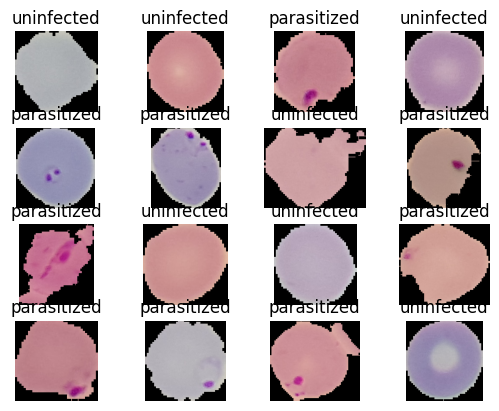

In [153]:

for i , (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Data preprocessing

## Data Argumentation

In [154]:
def visualize(orignal, argumented):
    plt.subplot(1,2,1)
    plt.imshow(orignal)

    plt.subplot(1,2,2)
    plt.imshow(argumented)

In [155]:
orignal_image, label = next(iter(train_dataset))

In [156]:
argumented_image = tf.image.central_crop(orignal_image, 0.8)

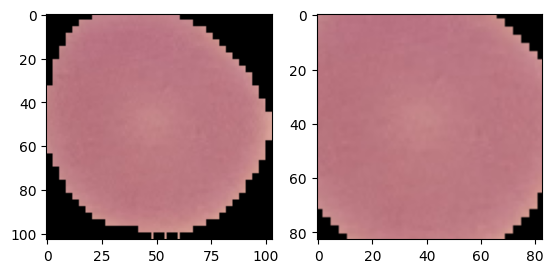

In [157]:
visualize(orignal_image, argumented_image)

In [158]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/ 255.0, label

In [159]:
#data argumentation using tf.image
def argument(image, label):
    image , label = resize_rescale(image, label)

    image = tf.image.rot90(image, k = 1)
    image = tf.image.flip_left_right(image)

    return image, label

In [160]:
# data argumentation using tf.keras.layers
argument_layers = tf.keras.Sequential([
    RandomRotation(factor = (0.25, 0.2501)),
    RandomFlip(mode = 'horizontal')
])

def argument_layer(image, label):
    image , label = resize_rescale(image, label)
    return argument_layers(image , training = True), label

In [161]:
test_dataset = test_dataset.map(argument_layer)

In [162]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [163]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size= 8, reshuffle_each_iteration= True)
    .map(argument_layer)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    val_dataset
    .shuffle(buffer_size= 8, reshuffle_each_iteration= True)
    .map(argument_layer)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Model Creation and Training

In [164]:
dropout_rate = 0.2
regularizing_rate = 0.01
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu', kernel_regularizer = L2(regularizing_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    Dropout(rate = dropout_rate),

    Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu', kernel_regularizer = L2(regularizing_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    Dense(100, activation = 'relu', kernel_regularizer = L2(regularizing_rate)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),
    Dense(10, activation = 'relu', kernel_regularizer = L2(regularizing_rate)),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid'),
])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_76 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 111, 111, 6)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_77 (Ba  (None, 109, 109, 16)    

In [165]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
x = Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)
x = Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = "feature_extractor")
feature_extractor_model.summary()


Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_44 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_80 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_81 (Ba  (None, 109, 109, 16)

In [166]:
feature_extractor_seq = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
])
feature_extractor_seq.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_82 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_83 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                     

In [167]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
# x = feature_extractor_model(func_input)
x = feature_extractor_seq(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)


lenet_model_func = Model(func_input, func_output, name = "lenet_Model")
lenet_model_func.summary()


Model: "lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_20 (Sequential)  (None, 54, 54, 16)        1136      
                                                                 
 flatten_18 (Flatten)        (None, 46656)             0         
                                                                 
 dense_54 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_84 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_55 (Dense)            (None, 10)                1010      
                                                       

# Model Subclassing

In [168]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, padding, strides, activation, pool_size):
    super(FeatureExtractor, self).__init__()
    self.conv1 = Conv2D(filters = filters , kernel_size = kernel_size, padding = padding, strides = strides, activation = activation)
    self.bn1 = BatchNormalization()
    self.maxpool1 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

    self.conv2 = Conv2D(filters = 2*filters , kernel_size = kernel_size, padding = padding, strides = strides, activation = activation)
    self.bn2 = BatchNormalization()
    self.maxpool2 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

  def call(self, x, training):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.maxpool2(x)
    return x

feature_sub_classed = FeatureExtractor(8, 3, 'valid', 1, 'relu', 2)


In [169]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
x = feature_sub_classed(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)


lenet_model_func = Model(func_input, func_output, name = "lenet_Model")
lenet_model_func.summary()


Model: "lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_8 (Featu  (None, 54, 54, 16)        1488      
 reExtractor)                                                    
                                                                 
 flatten_19 (Flatten)        (None, 46656)             0         
                                                                 
 dense_57 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_88 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_58 (Dense)            (None, 10)                

In [170]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()
    self.feature_extractor = FeatureExtractor(8, 3, 'valid', 1, 'relu', 2)

    self.flatten = Flatten()
    self.dense1 = Dense(100, activation = 'relu')

    self.bn1 = BatchNormalization()
    self.dense2 = Dense(10, activation = 'relu')
    self.bn2 = BatchNormalization()

    self.dense3 = Dense(1, activation = 'sigmoid')

  def call(self, x, training):
    x = self.feature_extractor(x)

    x = self.flatten(x)

    x = self.dense1(x)
    x = self.bn1(x)

    x = self.dense2(x)
    x = self.bn2(x)

    x = self.dense3(x)
    return x

lenet_subclassed_model = LenetModel()
lenet_subclassed_model(tf.zeros([1, 224, 224, 3]), training = False)
lenet_subclassed_model.summary()

Model: "lenet_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_9 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_20 (Flatten)        multiple                  0         
                                                                 
 dense_60 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_92 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_61 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_93 (Ba  multiple                

# Callbacks

In [171]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print(f'\n for epoch number {epoch} the model has loss of {logs["loss"]}')
    def on_batch_end(self, batch, logs):
        print(f'\n for batch number {batch} the model has loss of {logs}')

## CSV Logger

In [172]:
csv_callback = CSVLogger(
    'logs.csv',
    separator = ',',
    append = False
)

## Early Stopping

In [173]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta = 0, patience = 2, verbose = 1, mode = 'auto', baseline = None, restore_best_weights = False
)

## Learning Rate Schedular

In [174]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

scheduler_callack = LearningRateScheduler(scheduler, verbose = 1)

## Model Checkpointing

In [175]:
checkpoint_callback = ModelCheckpoint(
    'ceheckpoints/', mode = 'auto', monitor = 'val_loss', save_best_only = True, save_weights_only = False, save_freq = 'epoch', verbose = 1
)

# Model Training

In [176]:
metrics = [TruePositives(name= 'tp'), FalsePositives(name = 'fp'), TrueNegatives(name = 'tn'), FalseNegatives(name = 'fn'),
           BinaryAccuracy(name = 'accuracy'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc')]

In [177]:
model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = metrics
)

In [178]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks = [scheduler_callack, checkpoint_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
689/689 [==============================] - ETA: 0s - loss: 4.3781 - tp: 9936.0000 - fp: 2524.0000 - tn: 8497.0000 - fn: 1089.0000 - accuracy: 0.8361 - precision: 0.7974 - recall: 0.9012 - auc: 0.8914
Epoch 1: val_loss improved from inf to 3.21691, saving model to ceheckpoints/
689/689 [==============================] - 700s 957ms/step - loss: 4.3781 - tp: 9936.0000 - fp: 2524.0000 - tn: 8497.0000 - fn: 1089.0000 - accuracy: 0.8361 - precision: 0.7974 - recall: 0.9012 - auc: 0.8914 - val_loss: 3.2169 - val_tp: 1298.0000 - val_fp: 94.0000 - val_tn: 1265.0000 - val_fn: 98.0000 - val_accuracy: 0.9303 - val_precision: 0.9325 - val_recall: 0.9298 - val_auc: 0.9511 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10
689/689 [==============================] - ETA: 0s - loss: 3.6503 - tp: 10527.0000 - fp: 1644.0000 - tn: 9377.0000 - fn: 498.0000 - accuracy

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model performance')
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.legend(['train', 'val performance'])
plt.show()

# Model Evaluation and Testing

In [ ]:
test_dataset

In [ ]:
train_dataset

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

In [ ]:
model.evaluate(test_dataset)

In [ ]:
model.predict(test_dataset.take(1))[0][0]

# Visualizing Confusion matrix

In [ ]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:,0, ...].shape)

In [ ]:
labels = np.array([i[0] for i in labels])

In [ ]:
labels

In [ ]:
predicted = model.predict(np.array(inp)[:,0, ...])
predicted[:, 0]

In [ ]:
threshold = 0.41

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize = (8,8))

sns.heatmap(cm, annot=True)
plt.title('confusion matrix - {}'.format(threshold))
plt.ylabel('actual')
plt.xlabel('predicted')


# ROC plot

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.figure(figsize=(16, 12))
plt.plot(fp, tp)
plt.xlabel('False positive rate')
plt.ylabel('true positive rate')
plt.grid()

skip = 20
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])
plt.show()

In [ ]:
def parasite_or_not(x):
  if(x < 0.5):
    return 'P'
  else:
    return 'U'

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])


In [ ]:
for i , (image, label) in enumerate(test_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ':' + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

In [ ]:
# model.save('malaria_diagnosis.keras')